# Testing the trained model on a random (full) image with ortho only (4 channels RGBA)

Using device: cuda
4-CHANNEL RGBA SEGMENTATION
=== Loading RGBA image ===
Image loaded: RGBA (13281, 11367, 4)
=== Creating overlapping windows ===
Window size: (1280, 1280), Stride: 960
Created: 168 windows
=== Loading 4-channel model ===
Model loaded: 4 classes
=== Performing segmentation ===


Segmenting windows: 100%|██████████| 168/168 [00:01<00:00, 90.19it/s]


=== Combining predictions with center weighting ===


Combining with center weighting: 100%|██████████| 168/168 [00:05<00:00, 30.01it/s]


RAW combined segmentation saved at: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/4-channel\K_Bf_13a_png-ortho_RAW_combined_4ch.png
=== Applying simple cleanup ===
=== Saving results ===
Grayscale segmentation saved at: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/4-channel\K_Bf_13a_png-ortho_segmented_4ch.png
Colored segmentation saved at: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/4-channel\K_Bf_13a_png-ortho_segmented_colored_4ch.png
Class information saved at: C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/4-channel\K_Bf_13a_png-ortho_class_info_4ch.txt
=== Creating visualization ===


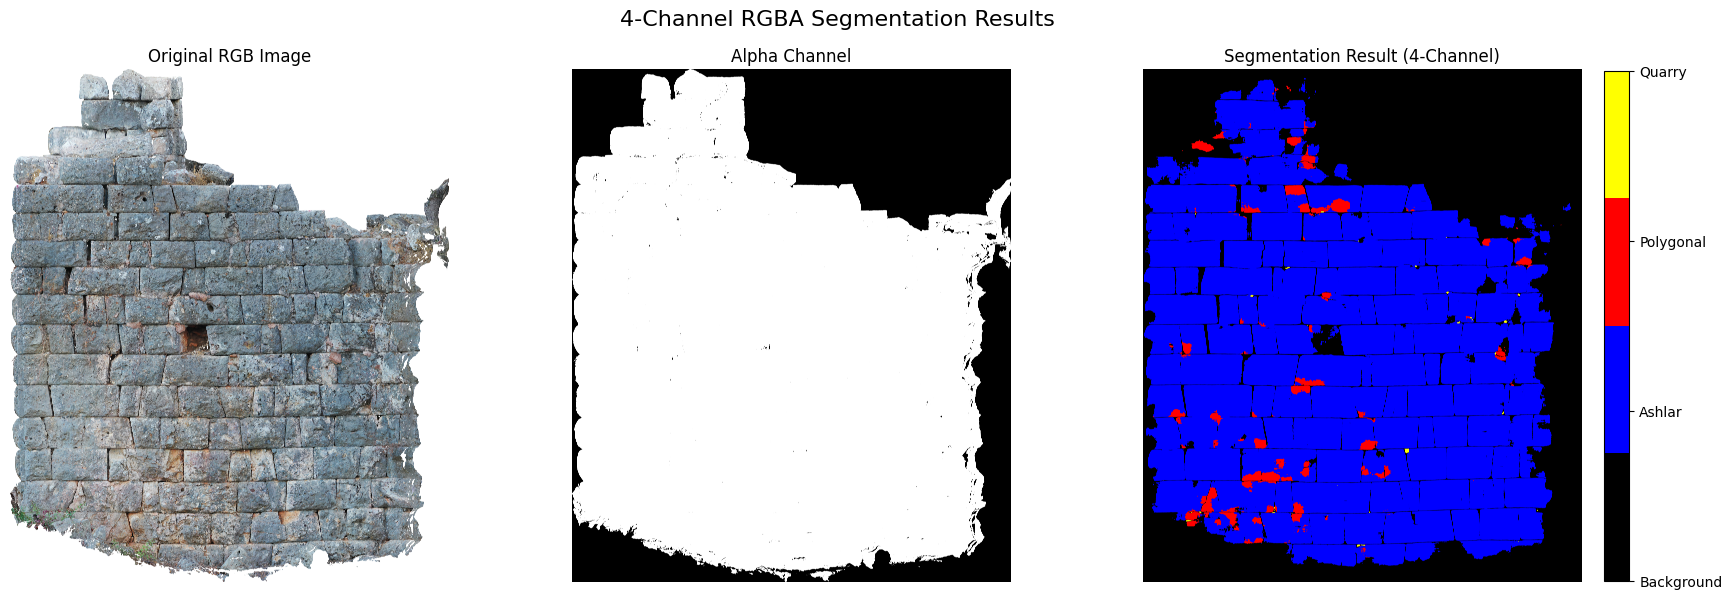

=== 4-Channel Segmentation complete! ===
This version uses:
- 4-channel RGBA input only (no normal maps)
- Original window size (1280x1280) for proper context
- Center-weighted combination to reduce edge artifacts
- Probability-based merging instead of hard voting
- Minimal post-processing to preserve model predictions


In [6]:
# ============================================================================
# STONE WALL SEGMENTATION WITH FIXED OVERLAP HANDLING - 4 CHANNEL VERSION
# ============================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import gc
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION SECTION - MODIFY THESE PARAMETERS
# ============================================================================

# === INPUT PATHS ===
RGBA_IMAGE_PATH ="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/03_orthos/K_Bf_13a_png-ortho.png"
MODEL_PATH = "C:/Users/admin/Documents/GitHub/ancientwallsegmentation/2025-08-11_4-channel_4-class-EX_300.pth"  # Path to your 4-channel model

# === OUTPUT PATH ===
OUTPUT_DIR ="C:/Users/admin/Desktop/AWS_TRAINING/2025-08-10_4classEX/testing/05_outputs/4-channel"

# === WINDOW PARAMETERS - BACK TO ORIGINAL ===
MODEL_SIZE = (512, 512)        # Size expected by the model
WINDOW_SIZE = (1280, 1280)     # Larger window for context
STRIDE = 960                   # 25% overlap

# === CLASS CONFIGURATION ===
CLASS_NAMES = [
    "Background",    # Class 0 - Black
    "Ashlar",       # Class 1 - Blue
    "Polygonal",    # Class 2 - Red  
    "Quarry"        # Class 3 - Yellow
]

CLASS_COLORS = [
    [0, 0, 0],      # Black - Background
    [0, 0, 255],    # Blue - Ashlar
    [255, 0, 0],    # Red - Polygonal
    [255, 255, 0]   # Yellow - Quarry
]

# === OVERLAP HANDLING ===
OVERLAP_METHOD = "center_weighted"  # Options: "average", "center_weighted", "max_confidence"

# === GPU/MEMORY MANAGEMENT ===
FALLBACK_TO_CPU = True          # Fallback to CPU if GPU runs out of memory

# === VISUALIZATION OPTIONS ===
SHOW_PLOTS = True               # Show matplotlib plots

# ============================================================================
# MODEL DEFINITION (DO NOT MODIFY)
# ============================================================================

class DoubleConv(nn.Module):
    """Double convolution block matching TensorFlow's implementation"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout_rate)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling exactly like TensorFlow's UpSampling2D + Conv2D"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.1):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv_after_up = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.conv = DoubleConv(in_channels, out_channels, dropout_rate)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv_after_up(x1)
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        if diffX != 0 or diffY != 0:
            x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                            diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class MultiUNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=5):  # Changed default to 4 channels
        super(MultiUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 16, 0.1)
        self.down1 = Down(16, 32, 0.1)
        self.down2 = Down(32, 64, 0.2)
        self.down3 = Down(64, 128, 0.2)
        self.down4 = Down(128, 256, 0.3)
        
        self.up1 = Up(256, 128, 0.2)
        self.up2 = Up(128, 64, 0.2)
        self.up3 = Up(64, 32, 0.1)
        self.up4 = Up(32, 16, 0.1)
        self.outc = nn.Conv2d(16, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# ============================================================================
# PROCESSING FUNCTIONS
# ============================================================================

def load_image(rgba_path):
    """Load RGBA image"""
    img_rgba = cv2.imread(rgba_path, cv2.IMREAD_UNCHANGED)
    if img_rgba is None:
        raise ValueError(f"Error loading RGBA image: {rgba_path}")
    if img_rgba.shape[2] != 4:
        print(f"WARNING: Image {rgba_path} doesn't have 4 channels, adding alpha channel.")
        alpha = np.ones((img_rgba.shape[0], img_rgba.shape[1], 1), dtype=img_rgba.dtype) * 255
        img_rgba = np.concatenate([img_rgba, alpha], axis=2)
    
    print(f"Image loaded: RGBA {img_rgba.shape}")
    return img_rgba

def create_sliding_windows(image, window_size, stride):
    """Create overlapping windows from an image"""
    height, width = image.shape[:2]
    windows = []
    positions = []
    
    for y in range(0, height, stride):
        for x in range(0, width, stride):
            y_end = min(y + window_size[0], height)
            x_end = min(x + window_size[1], width)
            
            y_start = max(0, y_end - window_size[0])
            x_start = max(0, x_end - window_size[1])
            
            window = image[y_start:y_end, x_start:x_end]
            
            if window.shape[0] != window_size[0] or window.shape[1] != window_size[1]:
                new_window = np.zeros((window_size[0], window_size[1], image.shape[2]), dtype=image.dtype)
                new_window[:window.shape[0], :window.shape[1]] = window
                window = new_window
                
            windows.append(window)
            positions.append((y_start, x_start, y_end, x_end))
    
    return windows, positions

def load_segmentation_model(model_path, device):
    """Load the pre-trained segmentation model"""
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    n_classes = checkpoint.get('n_classes', 5)
    img_channels = checkpoint.get('img_channels', 4)  # Default to 4 channels
    
    model = MultiUNet(n_channels=img_channels, n_classes=n_classes)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model = model.to(device)
    model.eval()
    
    return model, n_classes

def segment_window_with_probabilities(model, rgba, device='cuda'):
    """Segment a window using RGBA only and return both prediction and probabilities"""
    try:
        # Resize RGBA to model size
        rgba_resized = cv2.resize(rgba, MODEL_SIZE, interpolation=cv2.INTER_AREA)
        
        # Normalize to [0, 1]
        rgba_norm = rgba_resized.astype('float32') / 255.0
        
        # Convert to tensor (4 channels: R, G, B, A)
        input_tensor = torch.FloatTensor(rgba_norm).permute(2, 0, 1).unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_tensor)
            # Get probabilities with softmax
            probs = F.softmax(logits, dim=1)
            pred_label = torch.argmax(logits, dim=1)[0].cpu().numpy()
            probs_np = probs[0].cpu().numpy()  # Shape: (n_classes, 512, 512)
        
        if device == 'cuda':
            torch.cuda.empty_cache()
        
        # Resize predictions back to window size
        pred_label_resized = cv2.resize(pred_label.astype(np.uint8), 
                                       (WINDOW_SIZE[1], WINDOW_SIZE[0]), 
                                       interpolation=cv2.INTER_NEAREST)
        
        # Resize probabilities - use INTER_LINEAR for smooth probabilities
        probs_resized = np.zeros((probs_np.shape[0], WINDOW_SIZE[0], WINDOW_SIZE[1]), dtype=np.float32)
        for c in range(probs_np.shape[0]):
            probs_resized[c] = cv2.resize(probs_np[c], 
                                         (WINDOW_SIZE[1], WINDOW_SIZE[0]), 
                                         interpolation=cv2.INTER_LINEAR)
        
        return pred_label_resized, probs_resized
        
    except RuntimeError as e:
        if "out of memory" in str(e) and device == 'cuda' and FALLBACK_TO_CPU:
            print("GPU out of memory, falling back to CPU...")
            torch.cuda.empty_cache()
            gc.collect()
            model = model.to('cpu')
            return segment_window_with_probabilities(model, rgba, device='cpu')
        else:
            raise e

def combine_predictions_center_weighted(windows_data, positions, original_shape, n_classes):
    """Combine windows giving more weight to center pixels"""
    height, width = original_shape[:2]
    
    class_scores = np.zeros((height, width, n_classes), dtype=np.float32)
    weights = np.zeros((height, width), dtype=np.float32)
    
    # Create Gaussian-like weight for each window (center has more weight)
    h, w = WINDOW_SIZE
    y_coords, x_coords = np.ogrid[:h, :w]
    center_y, center_x = h / 2, w / 2
    
    # Distance from center
    dist = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    max_dist = np.sqrt(center_x**2 + center_y**2)
    
    # Weight: 1.0 at center, 0.3 at edges
    window_weight = 1.0 - (dist / max_dist) * 0.7
    
    with tqdm(total=len(windows_data), desc="Combining with center weighting") as pbar:
        for (pred, probs), (y_start, x_start, y_end, x_end) in zip(windows_data, positions):
            actual_h = y_end - y_start
            actual_w = x_end - x_start
            
            # Apply the weighted probabilities
            for c in range(n_classes):
                class_scores[y_start:y_end, x_start:x_end, c] += probs[c, :actual_h, :actual_w] * window_weight[:actual_h, :actual_w]
            
            weights[y_start:y_end, x_start:x_end] += window_weight[:actual_h, :actual_w]
            pbar.update(1)
    
    # Normalize by weights
    weights = np.maximum(weights, 1e-6)
    class_scores /= np.expand_dims(weights, axis=2)
    
    # Get final predictions
    segmentation = np.argmax(class_scores, axis=2).astype(np.uint8)
    
    return segmentation, class_scores

def simple_cleanup(segmentation):
    """Simple morphological cleanup without changing stone classifications"""
    cleaned = segmentation.copy()
    
    # Small median filter to smooth boundaries
    cleaned = cv2.medianBlur(cleaned.astype(np.uint8), 3)
    
    # Remove very small isolated pixels
    kernel = np.ones((3, 3), np.uint8)
    for class_id in range(1, 4):
        mask = (cleaned == class_id).astype(np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
        cleaned[cleaned == class_id] = 0
        cleaned[mask == 1] = class_id
    
    return cleaned

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def run_segmentation():
    """Main execution function for 4-channel RGBA segmentation"""
    
    # Setup
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print("="*50)
    print("4-CHANNEL RGBA SEGMENTATION")
    print("="*50)
    
    # Extract image name
    image_name = os.path.splitext(os.path.basename(RGBA_IMAGE_PATH))[0]
    
    # Load image
    print("=== Loading RGBA image ===")
    img_rgba = load_image(RGBA_IMAGE_PATH)
    
    # Create windows
    print("=== Creating overlapping windows ===")
    print(f"Window size: {WINDOW_SIZE}, Stride: {STRIDE}")
    rgba_windows, positions = create_sliding_windows(img_rgba, WINDOW_SIZE, STRIDE)
    print(f"Created: {len(rgba_windows)} windows")
    
    # Load model
    print("=== Loading 4-channel model ===")
    model, n_classes = load_segmentation_model(MODEL_PATH, device)
    print(f"Model loaded: {n_classes} classes")
    
    # Validate class configuration
    if n_classes > len(CLASS_NAMES):
        print(f"WARNING: Model has {n_classes} classes, but only {len(CLASS_NAMES)} names defined!")
        for i in range(len(CLASS_NAMES), n_classes):
            CLASS_NAMES.append(f"Class {i}")
            color = cm.get_cmap('tab10')(i / 10)[:3]
            CLASS_COLORS.append((np.array(color) * 255).astype(int).tolist())
    
    # Perform segmentation with probabilities
    print("=== Performing segmentation ===")
    windows_data = []
    
    with tqdm(total=len(rgba_windows), desc="Segmenting windows") as pbar:
        for i in range(len(rgba_windows)):
            pred, probs = segment_window_with_probabilities(
                model, rgba_windows[i], device
            )
            windows_data.append((pred, probs))
            pbar.update(1)
            
            if i % 10 == 0 and device == 'cuda':
                torch.cuda.empty_cache()
    
    # Combine predictions with center weighting
    print("=== Combining predictions with center weighting ===")
    full_segmentation, class_scores = combine_predictions_center_weighted(
        windows_data, positions, img_rgba.shape, n_classes
    )
    
    # Save raw output
    colors = np.array(CLASS_COLORS[:n_classes])
    output_raw_path = os.path.join(OUTPUT_DIR, f"{image_name}_RAW_combined_4ch.png")
    colored_raw = np.zeros((full_segmentation.shape[0], full_segmentation.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_raw[full_segmentation == i] = colors[i]
    colored_raw_bgr = cv2.cvtColor(colored_raw, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_raw_path, colored_raw_bgr)
    print(f"RAW combined segmentation saved at: {output_raw_path}")
    
    # Apply simple cleanup
    print("=== Applying simple cleanup ===")
    full_segmentation = simple_cleanup(full_segmentation)
    
    # Save results
    print("=== Saving results ===")
    
    # Save grayscale segmentation
    output_path = os.path.join(OUTPUT_DIR, f"{image_name}_segmented_4ch.png")
    cv2.imwrite(output_path, full_segmentation)
    print(f"Grayscale segmentation saved at: {output_path}")
    
    # Save colored segmentation
    colored_segmentation = np.zeros((full_segmentation.shape[0], full_segmentation.shape[1], 3), dtype=np.uint8)
    for i in range(n_classes):
        colored_segmentation[full_segmentation == i] = colors[i]
    
    colored_segmentation_bgr = cv2.cvtColor(colored_segmentation, cv2.COLOR_RGB2BGR)
    output_colored_path = os.path.join(OUTPUT_DIR, f"{image_name}_segmented_colored_4ch.png")
    cv2.imwrite(output_colored_path, colored_segmentation_bgr)
    print(f"Colored segmentation saved at: {output_colored_path}")
    
    # Save class information
    info_path = os.path.join(OUTPUT_DIR, f"{image_name}_class_info_4ch.txt")
    with open(info_path, 'w') as f:
        f.write("4-Channel RGBA Segmentation - Class Information:\n")
        f.write("-" * 50 + "\n")
        f.write(f"Input channels: 4 (RGBA)\n")
        f.write(f"Window size: {WINDOW_SIZE}\n")
        f.write(f"Model input size: {MODEL_SIZE}\n")
        f.write(f"Stride: {STRIDE}\n")
        f.write(f"Overlap method: {OVERLAP_METHOD}\n")
        f.write("-" * 50 + "\n")
        
        for i in range(n_classes):
            pixel_count = np.sum(full_segmentation == i)
            percentage = (pixel_count / full_segmentation.size) * 100
            f.write(f"Class {i}: {CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'Class {i}'}\n")
            f.write(f"  Color: RGB{tuple(colors[i])}\n")
            f.write(f"  Pixels: {pixel_count:,}\n")
            f.write(f"  Coverage: {percentage:.2f}%\n")
    
    print(f"Class information saved at: {info_path}")
    
    # Visualization
    if SHOW_PLOTS:
        print("=== Creating visualization ===")
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original RGB image
        rgb = img_rgba[:, :, :3]
        rgb_display = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        axes[0].imshow(rgb_display)
        axes[0].set_title("Original RGB Image")
        axes[0].axis("off")
        
        # Alpha channel visualization
        alpha = img_rgba[:, :, 3]
        axes[1].imshow(alpha, cmap='gray')
        axes[1].set_title("Alpha Channel")
        axes[1].axis("off")
        
        # Segmentation result
        cmap_seg = ListedColormap([np.array(color)/255.0 for color in CLASS_COLORS[:n_classes]])
        im = axes[2].imshow(full_segmentation, cmap=cmap_seg, vmin=0, vmax=n_classes-1)
        axes[2].set_title("Segmentation Result (4-Channel)")
        axes[2].axis("off")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
        cbar.set_ticks(range(n_classes))
        cbar.set_ticklabels([CLASS_NAMES[i] if i < len(CLASS_NAMES) else f'Class {i}' for i in range(n_classes)])
        
        plt.suptitle("4-Channel RGBA Segmentation Results", fontsize=16)
        plt.tight_layout()
        plt.show()
    
    return full_segmentation, colored_segmentation

# ============================================================================
# RUN THE SEGMENTATION
# ============================================================================

if __name__ == "__main__":
    segmentation_result, colored_result = run_segmentation()
    print("=== 4-Channel Segmentation complete! ===")
    print("This version uses:")
    print("- 4-channel RGBA input only (no normal maps)")
    print("- Original window size (1280x1280) for proper context")
    print("- Center-weighted combination to reduce edge artifacts")
    print("- Probability-based merging instead of hard voting")
    print("- Minimal post-processing to preserve model predictions")